In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D

In [10]:
import sys
sys.path.append('../')

from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers

In [11]:
# Import series of helper functions for the notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves

In [12]:
# Check GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocessing

In [13]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

## Hyperparameter

In [14]:
input_size = (28, 28, 1) # The image size of the MNIST
patch_size = (2, 2) # Segment 28-by-28 frames into 2-by-2 sized patches, patch contents and positions are embedded
n_labels = 10 # MNIST labels

# Dropout parameters
mlp_drop_rate = 0.01 # Droupout after each MLP layer
attn_drop_rate = 0.01 # Dropout after Swin-Attention
proj_drop_rate = 0.01 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
drop_path_rate = 0.01 # Drop-path within skip-connections

# Self-attention parameters 
# (Fixed for all the blocks in this configuration, but can vary per block in larger architectures)
num_heads = 8 # Number of attention heads
embed_dim = 64 # Number of embedded dimensions
num_mlp = 256 # Number of MLP nodes
qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor

# Shift-window parameters
window_size = 2 # Size of attention window (height = width)
shift_size = window_size // 2 # Size of shifting (shift_size < window_size)

num_patch_x = input_size[0]//patch_size[0]
num_patch_y = input_size[1]//patch_size[1]

## Model configuration

In [15]:
# The input section
IN = Input(input_size)
X = IN

# Extract patches from the input tensor
X = transformer_layers.patch_extract(patch_size)(X)

# Embed patches to tokens
X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)

# -------------------- Swin transformers -------------------- #
# Stage 1: window-attention + Swin-attention + patch-merging

for i in range(2):
    
    if i % 2 == 0:
        shift_size_temp = 0
    else:
        shift_size_temp = shift_size

    X = swin_layers.SwinTransformerBlock(dim=embed_dim, num_patch=(num_patch_x, num_patch_y), num_heads=num_heads, 
                             window_size=window_size, shift_size=shift_size_temp, num_mlp=num_mlp, qkv_bias=qkv_bias, qk_scale=qk_scale,
                             mlp_drop=mlp_drop_rate, attn_drop=attn_drop_rate, proj_drop=proj_drop_rate, drop_path_prob=drop_path_rate, 
                             name='swin_block{}'.format(i))(X)
# Patch-merging
#    Pooling patch sequences. Half the number of patches (skip every two patches) and double the embedded dimensions
X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)

# ----------------------------------------------------------- #

# Convert embedded tokens (2D) to vectors (1D)
X = GlobalAveragePooling1D()(X)

# The output section
OUT = Dense(n_labels, activation='softmax')(X)

In [16]:
# Model configuration
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 patch_extract (patch_extrac  (None, 196, 4)           0         
 t)                                                              
                                                                 
 patch_embedding (patch_embe  (None, 196, 64)          12864     
 dding)                                                          
                                                                 
 swin_transformer_block (Swi  (None, 196, 64)          50072     
 nTransformerBlock)                                              
                                                                 
 swin_transformer_block_1 (S  (None, 196, 64)          50856     
 winTransformerBlock)                                        

In [18]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy',])

# Training
SAVE_DIR = "./logs"
model_history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.1, 
                          callbacks=[create_tensorboard_callback(SAVE_DIR, "Swim_model")])

Saving TensorBoard log files to: ./logs/Swim_model/20240217-142945
Layer patch_extract has arguments ['patch_size']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/5
1688/1688 [==============================] - 57s 31ms/step - loss: 0.3676 - accuracy: 0.8821 - val_loss: 0.1495 - val_accuracy: 0.9560
Epoch 2/5
1688/1688 [==============================] - 61s 36ms/step - loss: 0.1815 - accuracy: 0.9437 - val_loss: 0.1292 - val_accuracy: 0.9620
Epoch 3/5
1688/1688 [==============================] - 49s 29ms/step - loss: 0.1488 - accuracy: 0.9530 - val_loss: 0.1118 - val_accuracy: 0.9657
Epoch 4/5
1688/1688 [=======================

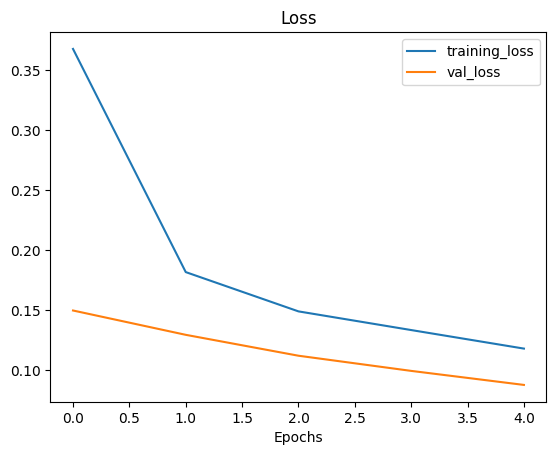

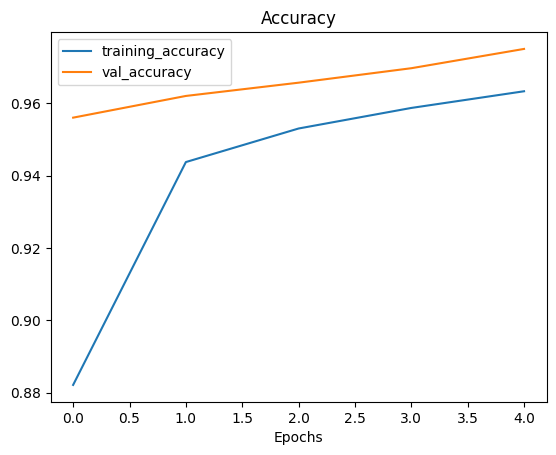

In [19]:
plot_loss_curves(model_history)
plt.show()

## Evaluate

In [20]:
# Make predictions on the validation data

model_pred_probs = model.predict(x_test)
model_pred_probs.shape, model_pred_probs[:10]

313/313 [==============================] - 3s 9ms/step


((10000, 10),
 array([[3.80356552e-10, 3.59005270e-07, 1.63599486e-06, 4.34768190e-05,
         7.04813630e-08, 3.25047794e-10, 3.92655174e-13, 9.99943614e-01,
         5.74201664e-09, 1.08320037e-05],
        [1.39295228e-03, 6.79993944e-04, 9.96731281e-01, 1.11135561e-03,
         3.86447496e-09, 3.83354752e-08, 7.38297895e-05, 2.08755804e-08,
         1.05752906e-05, 5.29442623e-09],
        [6.54992718e-08, 9.99100685e-01, 1.05706185e-05, 9.65970571e-07,
         6.02829619e-04, 2.27632427e-07, 2.55674126e-06, 2.57406296e-04,
         2.42054593e-05, 4.63134455e-07],
        [9.99111235e-01, 4.26938129e-08, 3.27241840e-04, 5.10186783e-06,
         2.99100680e-06, 5.95157326e-06, 5.13734354e-04, 1.17103218e-05,
         4.32896989e-08, 2.19535050e-05],
        [2.29939978e-09, 1.45429686e-08, 2.90040152e-08, 1.30974120e-09,
         9.99950051e-01, 5.73551540e-10, 6.86915325e-09, 1.77732407e-08,
         6.55124524e-08, 4.98859736e-05],
        [3.88569488e-09, 9.99819696e-01, 8.254

In [21]:
# Convert prediction probabilities to prediction classes

model_preds = tf.squeeze(tf.round(model_pred_probs))
model_preds[:10]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

    # Convert one-hot encoded labels to class labels
    y_true_classes = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true
    y_pred_classes = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true_classes, y_pred_classes) * 100
    
    # Calculate model precision, recall, and f1 score using "weighted average"
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [23]:
model_results = calculate_results(y_true=y_test, y_pred=model_preds)
model_results

{'accuracy': 96.39,
 'precision': 0.964702978757739,
 'recall': 0.9639,
 'f1': 0.9639436177028862}